In [ ]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime
from tensorflow import keras
import scipy as sp
#from scipy import sparse
from keras.layers import BatchNormalization
from tensorflow.keras import activations
import pandas as pd
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LayerNormalization
from sklearn.utils import class_weight
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef



### Importing dataset

reading csv from a local drive

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving subset_2class_agg.csv to subset_2class_agg.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['subset_2class_agg.csv']))
# Dataset is now stored in a Pandas Dataframe

##CNN Architecture

Even if a typical input is a 2D matrix representation of the
image, 1D convolutional layers in the network can deal with numerical inputs. We have used the CNN with 1D convolution layers for our non-image dataset. CNN models have been trained on standardised data only and have been designed in two ways: one – directly built for four classes outcome variable, and another – created using transfer learning methodology by taking weights from a CNN model with two classes target variable and freezing the first five convolution building blocks. 

The same architecture has been used for all the models (except the loss function and and the activation function of the final dense layer which changes for the binary outcome): seven convolution building blocks (3 blocks with 64 filters, 2 blocks - with 128 filters and 2 blocks - with 256), a flatten layer and two fully connected layers. The size of the kernel has been chosen as 1, as we use non-image data. No padding has been applied either (setting parameter padding to “valid”). Padding refers to adding pixels to the edges of the image, and thus is non-applicable in our case. Batch normalisation is applied in each convolution building block before passing the feature maps to a nonlinear activation function (to stabilise and accelerate the learning process). The feature maps are then passed to a nonlinear activation function (the rectified linear unit (ReLu) function which is defined as: f(x)=max(0,x)). In a classical CNN structure, the output of the activation function is then pulled to a pooling layer representing a downsampling technique, reducing the dimensions of feature maps. As we do not use the images input, we just pass the kernel size as 1 during the convolution step, and so no pooling is needed in our case. After going through all the convolution building blocks, the output tensor is flattened to a one-dimensional vector and passed to fully connected layers also called dense, where each input is connected to each output by a learnable weight. The activation function of the fully connected layers except the last one is also ReLu. The last fully connected layer transforms the output tensors into probabilities of each class summing up to 1. The activation function for this layer is soft-max for the model directly built for the four classes output and sigmoid for the binary outcome model trained for the transfer learning approach.

The loss function is categorical cross-entropy for the four classes output model and binary cross-entropy for the binary outcome.

## Training parameters:
- dynamic learning rate schedule with 0.01 learning rate for the first 20 epochs, 0.0001 - for the next 20 epochs and then - 0.00001 for the remaining epochs;
- number of epochs – 60;
- batch size - 32.

# 1. CNN Model for two classes output

Preparing data

In [ ]:
df_X=df.drop(columns=['Num_Acc', 'severity', 'severity2', 'journey_reason', 'atmospheric_cond', 'road_type', 'surface_state', 'road_slope', 
                      'junction_type','secu_equipment', 'traffic_type', 'acc_place_on_road'])


In [ ]:
#getting list of categorical columns
var2=list(df_X.select_dtypes(include='object').columns)
#getting list of numerical columns
varn=list(df_X.select_dtypes(include='number').columns)

In [ ]:
#formatting all categorical variables as strings
df_X[var2]=df_X[var2].astype(str)

In [ ]:
#formatting target variable
factor=pd.factorize(df['severity2'])
df['fact_y']=factor[0]
y= df['fact_y'].values

In [ ]:
# prepare input data with standardisation
def prepare_inputs(df, X_train, X_test): 
  continuous = list(df.select_dtypes(include='number').columns) 
  categorical = list(df.select_dtypes(include='object').columns)
	# standardizing scaling each continuous feature column 
  cs = StandardScaler()
  trainContinuous = cs.fit_transform(X_train[continuous])
  testContinuous = cs.transform(X_test[continuous])
  #one-hot encoding for categorical features
  Binarizer= OneHotEncoder().fit(df[categorical])
  trainCategorical = Binarizer.transform(X_train[categorical])
  testCategorical = Binarizer.transform(X_test[categorical])
  #adding standardisation for categorical variables
  scaler = StandardScaler(with_mean=False)
  trainCategorical2 = scaler.fit_transform(trainCategorical)
  testCategorical2 = scaler.transform(testCategorical)

	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
  trainX = np.hstack([trainCategorical2.toarray(),trainContinuous])
  testX = np.hstack([testCategorical2.toarray(),testContinuous])
	# return the concatenated training and testing data
  return (trainX, testX)

# prepare target
def prepare_targets(y_train, y_test):
  le = LabelEncoder().fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  y_test_enc_inv=le.inverse_transform(y_test_enc)
  return y_train_enc, y_test_enc, y_test_enc_inv

In [ ]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.33, random_state=1)


In [ ]:
# prepare input data
trainX, testX= prepare_inputs(df_X, X_train, X_test)
# prepare output data
y_train_enc, y_test_enc, y_test_enc_inv = prepare_targets(y_train, y_test)

In [ ]:
#reshaping the data for convolutional layers
trainX2=trainX.reshape(trainX.shape[0],trainX.shape[1],1)
testX2=testX.reshape(testX.shape[0],testX.shape[1],1)

###adding checkpoint and lr schedule


In [ ]:

checkpoint_path = "training_8/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
def sched(epoch):
  if epoch<=20:
    return 1e-2
  elif epoch<=40:
    return 1e-4
  else:
    return 1e-5
lr_schedule=LearningRateScheduler(sched)

In [ ]:
#creating layers
conv_1=tf.keras.layers.Conv1D(filters=64, kernel_size=1, kernel_regularizer='l1', padding='valid', input_shape=(trainX2.shape[1],1))
conv_2=tf.keras.layers.Conv1D(filters=128, kernel_size=1, kernel_regularizer='l1', padding='valid')
conv_3=tf.keras.layers.Conv1D(filters=256, kernel_size=1, kernel_regularizer='l1', padding='valid')
conv_layer2=tf.keras.layers.Conv1D(filters=64,kernel_size=1,padding='valid')
conv_layer2_2=tf.keras.layers.Conv1D(filters=64,kernel_size=1,padding='valid')
conv_layer3=tf.keras.layers.Conv1D(filters=128,kernel_size=1,padding='valid')
conv_layer3_3=tf.keras.layers.Conv1D(filters=128,kernel_size=1,padding='valid')

conv_layer4=tf.keras.layers.Conv1D(filters=256,kernel_size=1,padding='valid')
conv_layer4_3=tf.keras.layers.Conv1D(filters=256,kernel_size=1,padding='valid')

flat_layer=Flatten()
dense_1=Dense(128, activation='relu', kernel_regularizer='l1')

dense_2=Dense(1, activation='sigmoid')

In [ ]:
#creating model
mod2=Sequential()
mod2.add(conv_1)
mod2.add(tf.keras.layers.BatchNormalization())
mod2.add(tf.keras.layers.Activation('relu'))


mod2.add(conv_layer2)
mod2.add(tf.keras.layers.BatchNormalization())
mod2.add(tf.keras.layers.Activation('relu'))


mod2.add(conv_layer2_2)
mod2.add(tf.keras.layers.BatchNormalization())
mod2.add(tf.keras.layers.Activation('relu'))


mod2.add(conv_layer3)
mod2.add(tf.keras.layers.BatchNormalization())
mod2.add(tf.keras.layers.Activation('relu'))

mod2.add(conv_layer3_3)
mod2.add(tf.keras.layers.BatchNormalization())
mod2.add(tf.keras.layers.Activation('relu'))

mod2.add(conv_layer4)
mod2.add(tf.keras.layers.BatchNormalization())
mod2.add(tf.keras.layers.Activation('relu'))

mod2.add(conv_layer4_3)
mod2.add(tf.keras.layers.BatchNormalization())
mod2.add(tf.keras.layers.Activation('relu'))


mod2.add(flat_layer)
mod2.add(dense_1)
mod2.add(dense_2)

mod2.summary()

mod2.output_shape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 64)            128       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 14, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14, 64)            4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 64)            256       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 14, 64)            4

(None, 1)

Epoch 1/60
5337/5337 [==============================] - 53s 10ms/step - loss: 6.1315 - accuracy: 0.6175 - val_loss: 5.6199 - val_accuracy: 0.5944

Epoch 00001: saving model to training_8/cp.ckpt
Epoch 2/60
5337/5337 [==============================] - 50s 9ms/step - loss: 5.6304 - accuracy: 0.6342 - val_loss: 5.8008 - val_accuracy: 0.5586

Epoch 00002: saving model to training_8/cp.ckpt
Epoch 3/60
5337/5337 [==============================] - 49s 9ms/step - loss: 5.6317 - accuracy: 0.6301 - val_loss: 5.5946 - val_accuracy: 0.5782

Epoch 00003: saving model to training_8/cp.ckpt
Epoch 4/60
5337/5337 [==============================] - 49s 9ms/step - loss: 5.6216 - accuracy: 0.6417 - val_loss: 5.6374 - val_accuracy: 0.6425

Epoch 00004: saving model to training_8/cp.ckpt
Epoch 5/60
5337/5337 [==============================] - 50s 9ms/step - loss: 5.6247 - accuracy: 0.6366 - val_loss: 5.6151 - val_accuracy: 0.6456

Epoch 00005: saving model to training_8/cp.ckpt
Epoch 6/60
5337/5337 [=======

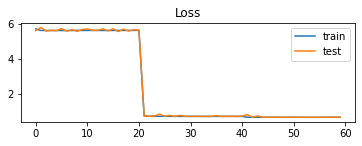

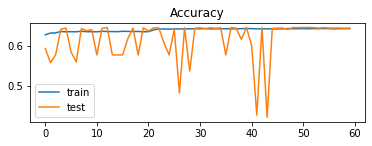

In [ ]:
#compile the model
mod2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the model on the dataset
history=mod2.fit(trainX2, y_train_enc, epochs=60, batch_size=32, shuffle=True, callbacks=[lr_schedule,cp_callback], validation_data=(testX2, y_test_enc), verbose=1)
# evaluate the model
_, train_acc = mod2.evaluate(trainX2, y_train_enc, verbose=0)
_, test_acc = mod2.evaluate(testX2, y_test_enc, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# predict probabilities for test set
yh_probs = mod2.predict(testX2, verbose=0)
# predict classes for test set
yh_classes = np.argmax(mod2.predict(testX2), axis=-1)

### Evaluating binary CNN Model

In [ ]:
#calculating macro-averaged accuracy metrics 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_enc_inv, yh_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_enc_inv, yh_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_enc_inv, yh_classes, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_enc_inv, yh_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.578186
Precision: 0.289093
Recall: 0.500000
F1 score: 0.366361


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_enc_inv, yh_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_enc_inv, yh_classes, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_enc_inv, yh_classes, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_enc_inv, yh_classes, average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.578186
Precision: 0.578186
Recall: 0.578186
F1 score: 0.578186


#2. Multiclass CNN model using transfer learning
After having trained the model for two classes (see the code above), we save the weights of the model and transfer them to the new model with the same structure, except the last dense layer, where for four-class CNN, we put the soft-max activation function instead of the sigmoid one. The training loss function in the new four classes model is again the categorical cross entropy. Before training the new model, we freeze several layers – all the convolution building blocks, except the last two. The idea behind this freezing lies in the fact, that the first convolution layers learn the general patterns of the data, so we can transfer this knowledge and use it in the new model without training again. The last convolution layers and the dense layers allow to learn the patterns specific to the task in hand, so need to be trained specifically for the new model. The training hyperparameters for the four-class CNN with transferred weights have been kept the same as in the previous cases.

In [ ]:
#preparing target variable
factor=pd.factorize(df['severity'])
df['fact_y_4class']=factor[0]
y4=df['fact_y_4class'].values

In [ ]:
# prepare input data with standardisation
def prepare_inputs(df, X_train, X_test): 
  continuous = list(df.select_dtypes(include='number').columns) 
  categorical = list(df.select_dtypes(include='object').columns)
	# performing standardizing scaling each continuous feature column 
  cs = StandardScaler()
  trainContinuous = cs.fit_transform(X_train[continuous])
  testContinuous = cs.transform(X_test[continuous])
  #one-hot encoding for categorical variables
  Binarizer= OneHotEncoder().fit(df[categorical])
  trainCategorical = Binarizer.transform(X_train[categorical])
  testCategorical = Binarizer.transform(X_test[categorical])
  #adding standardisation for categorical variables
  scaler = StandardScaler(with_mean=False)
  trainCategorical2 = scaler.fit_transform(trainCategorical)
  testCategorical2 = scaler.transform(testCategorical)

	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
  trainX = np.hstack([trainCategorical2.toarray(),trainContinuous])
  testX = np.hstack([testCategorical2.toarray(),testContinuous])
	# return the concatenated training and testing data
  return (trainX, testX)

# prepare target
def prepare_targets(y_train, y_test):
  le = LabelBinarizer().fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  y_test_enc_inv=le.inverse_transform(y_test_enc)
  return y_train_enc, y_test_enc, y_test_enc_inv

In [ ]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, y4, test_size=0.33, random_state=1)

In [ ]:
# prepare input data
trainX, testX= prepare_inputs(df_X, X_train, X_test)
# prepare output data
y_train_enc, y_test_enc, y_test_enc_inv = prepare_targets(y_train, y_test)


In [ ]:
#reshaping the data for convolutional layers
trainX2=trainX.reshape(trainX.shape[0],trainX.shape[1],1)
testX2=testX.reshape(testX.shape[0],testX.shape[1],1)

In [ ]:
#computing class weights to handle imbalance
y_integers = np.argmax(y_train_enc, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

In [ ]:
# adding dense layer with 4 classes
dense_2_4=Dense(4, activation='softmax')

In [ ]:
#transfer learning - saving weights of binary CNN model
mod2.save_weights("pretrained_weights.h5")

In [ ]:
#creating multiclass CNN model
model_4class=Sequential()
model_4class.add(conv_1)
model_4class.add(tf.keras.layers.BatchNormalization())
model_4class.add(tf.keras.layers.Activation('relu'))


model_4class.add(conv_layer2)
model_4class.add(tf.keras.layers.BatchNormalization())
model_4class.add(tf.keras.layers.Activation('relu'))


model_4class.add(conv_layer2_2)
model_4class.add(tf.keras.layers.BatchNormalization())
model_4class.add(tf.keras.layers.Activation('relu'))


model_4class.add(conv_layer3)
model_4class.add(tf.keras.layers.BatchNormalization())
model_4class.add(tf.keras.layers.Activation('relu'))

model_4class.add(conv_layer3_3)
model_4class.add(tf.keras.layers.BatchNormalization())
model_4class.add(tf.keras.layers.Activation('relu'))

model_4class.add(conv_layer4)
model_4class.add(tf.keras.layers.BatchNormalization())
model_4class.add(tf.keras.layers.Activation('relu'))

model_4class.add(conv_layer4_3)
model_4class.add(tf.keras.layers.BatchNormalization())
model_4class.add(tf.keras.layers.Activation('relu'))


model_4class.add(flat_layer)
model_4class.add(dense_1)
model_4class.add(dense_2)
model_4class.summary()

model_4class.output_shape

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 64)            128       
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 64)            256       
_________________________________________________________________
activation_10 (Activation)   (None, 14, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14, 64)            4160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 64)            256       
_________________________________________________________________
activation_11 (Activation)   (None, 14, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 14, 64)           

(None, 1)

In [ ]:
# In a separate program:
pretrained_model = model_4class
pretrained_model.load_weights("pretrained_weights.h5")

# Create a new model by extracting layers from the original model:
extracted_layers = pretrained_model.layers[:-1]
extracted_layers.append(dense_2_4)
model = keras.Sequential(extracted_layers)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 64)            128       
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 64)            256       
_________________________________________________________________
activation_10 (Activation)   (None, 14, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14, 64)            4160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 64)            256       
_________________________________________________________________
activation_11 (Activation)   (None, 14, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 14, 64)           

In [ ]:
#freezing layers
for layer in model.layers[:15]:
  layer.trainable = False

In [ ]:
#checking the number of trainable parameters
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 64)            128       
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 64)            256       
_________________________________________________________________
activation_10 (Activation)   (None, 14, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14, 64)            4160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 64)            256       
_________________________________________________________________
activation_11 (Activation)   (None, 14, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 14, 64)           

In [ ]:
#checking that two last conv layer building blocks are trainable
print("Total trainable weights: {}".format(len(model.trainable_weights)))
model.trainable_weights

Total trainable weights: 12


[<tf.Variable 'conv1d_7/kernel:0' shape=(1, 128, 256) dtype=float32, numpy=
 array([[[-0.00829667,  0.00122772,  0.00892232, ..., -0.11241094,
          -0.12502827,  0.1272691 ],
         [ 0.74347574,  0.0532034 , -0.26989642, ...,  0.17719142,
           1.2139083 , -0.18384384],
         [-0.26205343, -0.01139252, -0.21264097, ...,  0.00262624,
          -0.06714913,  0.00861629],
         ...,
         [-0.433182  ,  0.08131287, -0.6350561 , ..., -1.2647676 ,
           0.87294805, -0.06188029],
         [ 0.44650713, -0.02156608, -0.21137567, ...,  0.2610858 ,
           0.20350818,  0.06374488],
         [ 0.97738487,  0.17035767, -0.1164268 , ..., -0.4523791 ,
           0.42900398, -0.38697013]]], dtype=float32)>,
 <tf.Variable 'conv1d_7/bias:0' shape=(256,) dtype=float32, numpy=
 array([-0.00000075,  0.0000522 , -0.00012957, -0.00018636,  0.00004996,
         0.00001342,  0.00016799,  0.00005128, -0.0000065 ,  0.00002377,
         0.00007066, -0.00009471,  0.00033862, -0.0000

Epoch 1/60
5337/5337 [==============================] - 33s 6ms/step - loss: 6.2795 - accuracy: 0.4070 - val_loss: 14.4454 - val_accuracy: 0.4554
Epoch 2/60
5337/5337 [==============================] - 31s 6ms/step - loss: 6.0722 - accuracy: 0.4104 - val_loss: 5.2948 - val_accuracy: 0.4449
Epoch 3/60
5337/5337 [==============================] - 31s 6ms/step - loss: 6.0660 - accuracy: 0.4098 - val_loss: 13.8551 - val_accuracy: 0.4079
Epoch 4/60
5337/5337 [==============================] - 31s 6ms/step - loss: 6.0671 - accuracy: 0.4125 - val_loss: 8.0834 - val_accuracy: 0.4028
Epoch 5/60
5337/5337 [==============================] - 31s 6ms/step - loss: 6.0665 - accuracy: 0.4141 - val_loss: 2.1350 - val_accuracy: 0.3799
Epoch 6/60
5337/5337 [==============================] - 31s 6ms/step - loss: 6.0342 - accuracy: 0.4124 - val_loss: 9.1426 - val_accuracy: 0.4344
Epoch 7/60
5337/5337 [==============================] - 31s 6ms/step - loss: 6.0860 - accuracy: 0.4154 - val_loss: 2.2486 - val_

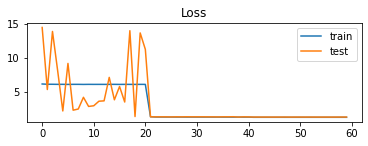

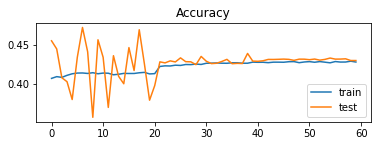

In [ ]:
#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the model on the dataset
history=model.fit(trainX2, y_train_enc, epochs=60, batch_size=32, shuffle=True, class_weight=d_class_weights, callbacks=lr_schedule, validation_data=(testX2, y_test_enc), verbose=1)
# evaluate the model
_, train_acc = model.evaluate(trainX2, y_train_enc, verbose=0)
_, test_acc = model.evaluate(testX2, y_test_enc, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# predict probabilities for test set
yh_probs = model.predict(testX2, verbose=0)
# predict classes for test set
yh_classes = np.argmax(model.predict(testX2), axis=-1)

### Evaluating Multiclass CNN with transfer learning

In [ ]:
#plotting classification report
clf_report = classification_report(y_test_enc_inv,
                                   yh_classes,
                                   target_names=list(factor[1]),
                                   output_dict=True)

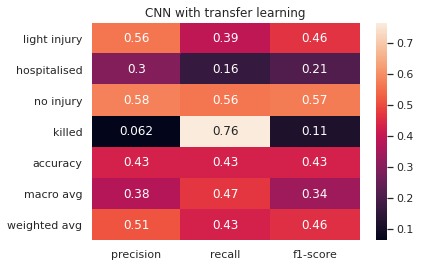

In [ ]:
sns.set(font_scale=1)
ax=sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title ("CNN with transfer learning")
plt.show()

Text(58.5, 0.5, 'True Classes')

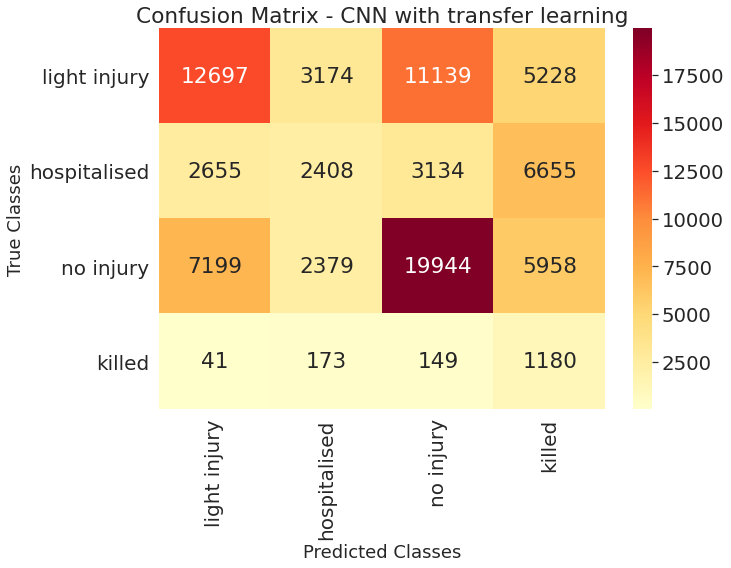

In [ ]:
#plotting confusion matrix
fig, ax = plt.subplots(figsize=(10,7)) 
sns.set(font_scale=1.8)
cm = confusion_matrix(y_test_enc_inv, yh_classes)
f = sns.heatmap(cm, cmap="YlOrRd", ax=ax,  fmt='g', annot=True)
# passing a list of labels
ax.set_xticklabels(list(factor[1]), fontsize=20, rotation=90)
ax.set_yticklabels(list(factor[1]), fontsize=20, rotation=360)
plt.title("Confusion Matrix - CNN with transfer learning")
plt.xlabel("Predicted Classes", fontsize=18)
plt.ylabel("True Classes", fontsize=18)

In [ ]:
#calculating Matthews coefficient
matthews_corrcoef(y_test_enc_inv, yh_classes)

0.1998828439631372

#3. Multiclass CNN Model without transfer learning

In [ ]:
#Creating the model
model_4class_2=Sequential()
model_4class_2.add(conv_1)
model_4class_2.add(tf.keras.layers.BatchNormalization())
model_4class_2.add(tf.keras.layers.Activation('relu'))


model_4class_2.add(conv_layer2)
model_4class_2.add(tf.keras.layers.BatchNormalization())
model_4class_2.add(tf.keras.layers.Activation('relu'))


model_4class_2.add(conv_layer2_2)
model_4class_2.add(tf.keras.layers.BatchNormalization())
model_4class_2.add(tf.keras.layers.Activation('relu'))


model_4class_2.add(conv_layer3)
model_4class_2.add(tf.keras.layers.BatchNormalization())
model_4class_2.add(tf.keras.layers.Activation('relu'))

model_4class_2.add(conv_layer3_3)
model_4class_2.add(tf.keras.layers.BatchNormalization())
model_4class_2.add(tf.keras.layers.Activation('relu'))

model_4class_2.add(conv_layer4)
model_4class_2.add(tf.keras.layers.BatchNormalization())
model_4class_2.add(tf.keras.layers.Activation('relu'))

model_4class_2.add(conv_layer4_3)
model_4class_2.add(tf.keras.layers.BatchNormalization())
model_4class_2.add(tf.keras.layers.Activation('relu'))


model_4class_2.add(flat_layer)
model_4class_2.add(dense_1)
model_4class_2.add(dense_2_4)
model_4class_2.summary()

model_4class_2.output_shape

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 64)            128       
_________________________________________________________________
batch_normalization_35 (Batc (None, 14, 64)            256       
_________________________________________________________________
activation_38 (Activation)   (None, 14, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14, 64)            4160      
_________________________________________________________________
batch_normalization_36 (Batc (None, 14, 64)            256       
_________________________________________________________________
activation_39 (Activation)   (None, 14, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 14, 64)           

(None, 4)

Epoch 1/60
5337/5337 [==============================] - 50s 9ms/step - loss: 6.9660 - accuracy: 0.3620 - val_loss: 8.6721 - val_accuracy: 0.3458
Epoch 2/60
5337/5337 [==============================] - 47s 9ms/step - loss: 6.4635 - accuracy: 0.4109 - val_loss: 6.4686 - val_accuracy: 0.3620
Epoch 3/60
5337/5337 [==============================] - 47s 9ms/step - loss: 6.4588 - accuracy: 0.4106 - val_loss: 8.5870 - val_accuracy: 0.3586
Epoch 4/60
5337/5337 [==============================] - 48s 9ms/step - loss: 6.4670 - accuracy: 0.4111 - val_loss: 6.8891 - val_accuracy: 0.4620
Epoch 5/60
5337/5337 [==============================] - 47s 9ms/step - loss: 6.4671 - accuracy: 0.4101 - val_loss: 5.6305 - val_accuracy: 0.3370
Epoch 6/60
5337/5337 [==============================] - 47s 9ms/step - loss: 6.4560 - accuracy: 0.4085 - val_loss: 7.3439 - val_accuracy: 0.3792
Epoch 7/60
5337/5337 [==============================] - 47s 9ms/step - loss: 6.4681 - accuracy: 0.4098 - val_loss: 5.5227 - val_ac

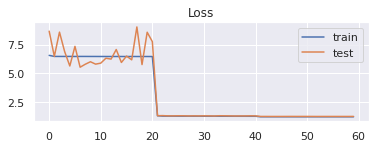

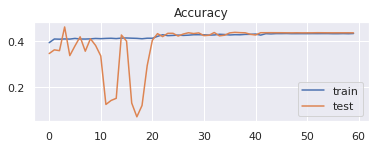

In [ ]:
#compile the model
model_4class_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the model on the dataset
history=model_4class_2.fit(trainX2, y_train_enc, epochs=60, batch_size=32, shuffle=True, class_weight=d_class_weights, callbacks=lr_schedule, validation_data=(testX2, y_test_enc), verbose=1)
# evaluate the model
_, train_acc = model_4class_2.evaluate(trainX2, y_train_enc, verbose=0)
_, test_acc = model_4class_2.evaluate(testX2, y_test_enc, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
sns.set(font_scale=1)
pyplot.subplot(211)
pyplot.rcParams['font.size'] = '16'
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# predict probabilities for test set
yh_probs = model.predict(testX2, verbose=0)
# predict classes for test set
yh_classes_no_tr = np.argmax(model.predict(testX2), axis=-1)

### Evaluating Multiclass CNN without transfer learning

In [ ]:
#plotting classification report
clf_report = classification_report(y_test_enc_inv,
                                   yh_classes_no_tr,
                                   target_names=list(factor[1]),
                                   output_dict=True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sns.set(font_scale=1)
ax=sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title ("CNN without transfer learning")
plt.show()

Text(66.5, 0.5, 'True Classes')

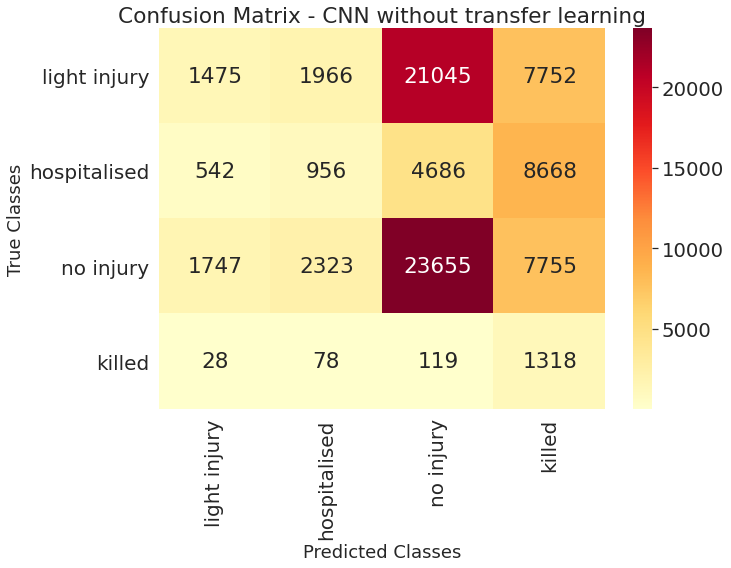

In [ ]:
#plotting confusion matrix
fig, ax = plt.subplots(figsize=(10,7)) 
sns.set(font_scale=1.8)
cm = confusion_matrix(y_test_enc_inv, yh_classes_no_tr)
f = sns.heatmap(cm, cmap="YlOrRd", ax=ax,  fmt='g', annot=True)
# passing a list of labels
ax.set_xticklabels(list(factor[1]), fontsize=20, rotation=90)
ax.set_yticklabels(list(factor[1]), fontsize=20, rotation=360)
plt.title("Confusion Matrix - CNN without transfer learning")
plt.xlabel("Predicted Classes", fontsize=18)
plt.ylabel("True Classes", fontsize=18)

In [ ]:
#Calculating Matthews coefficient
matthews_corrcoef(y_test_enc_inv, yh_classes_no_tr)

0.0727794653760182

## Results
The CNN model designed using the weights transferred from two-classes model performs much better than the CNN directly trained for four-classes outcome. All macro-averaged measures are better for the former than for the latter: F-1 score is 0.34 vs. 0.21, precision is 0.38 vs. 0.27 and recall is 0.47 vs. 0.41. The single-class metrics are also higher for the CNN with transfer learning: all individual class F1-scores are considerably better than the CNN without transfer learning ones. The Matthews Correlation Coefficient is again much higher for the model with transfer learning: 0.20 vs. 0.07 for the model directly built for the four classes output.
